In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles; 
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les 
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront 
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices 
# des sommets d'un element triangle, dans le sens antihoraire. 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ; 
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2)); 
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ; 
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1  
                coordinates[p,0] = x[i,0]  
                coordinates[p,1] = x[j,0] 
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1 
                    p3 = p1 + n 
                    p4 = p2 + n 
                    e = e + 1 
                    elements3[e,0] = p1 
                    elements3[e,1] = p2 
                    elements3[e,2] = p3 
                    e = e + 1
                    elements3[e,0] = p4 
                    elements3[e,1] = p3 
                    elements3[e,2] = p2 
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j  
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j 

    return coordinates, elements3,dirichlet, neumann

In [3]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()

**Partie I : maillage triangulaire et conditions de Dirichlet**

In [4]:
coordinates, elements3, dirichlet, neumann = maillage(10)

In [5]:
N_T = len(elements3)
N_S = len(coordinates)
M_T = np.ones((3,3))
A = np.zeros((N_S,N_S))
b_tp = np.zeros(3)
b_t = np.zeros(N_S)

U_k = np.zeros(N_S)
U_k[dirichlet] = 5

f = lambda x, y : x*y
g = lambda x, y : x+y
u_d = lambda x,y : x-y

for i in range(N_T) : 
    Tp = elements3[i] # Chaque ligne contient les indices des sommets d'un element triangle

    x1 = coordinates[Tp[0]][0]
    x2 = coordinates[Tp[1]][0]
    x3 = coordinates[Tp[2]][0]
    y1 = coordinates[Tp[0]][1]
    y2 = coordinates[Tp[1]][1]
    y3 = coordinates[Tp[2]][1]
    
    a = np.zeros((2,2))
    a[0,0] = x2 - x1
    a[0,1] = x3 - x1
    a[1,0] = y2 - y1
    a[1,1] = y3 - y1
    alpha =  np.linalg.det(a)

    grad1 = [y2 - y3, x3 - x1]/alpha
    grad2 = [y3-y1,x1-x2]/alpha
    grad3 = [y1-y2,x2-x3]/alpha

    M_T[0,0] = alpha/2 * np.dot(grad1, grad1)
    M_T[0,1] = alpha/2 * np.dot(grad1, grad2)
    M_T[0,2] = alpha/2 * np.dot(grad1, grad3)
    M_T[1,0] = alpha/2 * np.dot(grad2, grad1)
    M_T[1,1] = alpha/2 * np.dot(grad2, grad2)
    M_T[1,2] = alpha/2 * np.dot(grad2, grad3)
    M_T[2,0] = alpha/2 * np.dot(grad3, grad1)
    M_T[2,1] = alpha/2 * np.dot(grad3, grad2)
    M_T[2,2] = alpha/2 * np.dot(grad3, grad3)

    A[Tp, Tp[0]] = A[Tp, Tp[0]] + M_T[:,0]
    A[Tp, Tp[1]] = A[Tp, Tp[1]] + M_T[:,1]
    A[Tp, Tp[2]] = A[Tp, Tp[2]] + M_T[:,2]


    xg = (x1+x2+x3)/3
    yg = (y1+y2+y3)/3

    b_tp[0] = alpha/6 * f(xg,yg)
    b_tp[1] = alpha/6 * f(xg,yg)
    b_tp[2] = alpha/6 * f(xg,yg)

    b_t[Tp] = b_t[Tp] + b_tp
b_t = b_t - np.dot(A,U_k)

In [6]:
masque = np.ones(N_S, dtype=bool)
masque[dirichlet] = False
x = np.linalg.solve(A[np.ix_(masque,masque)], b[masque])
U_k[masque] = x

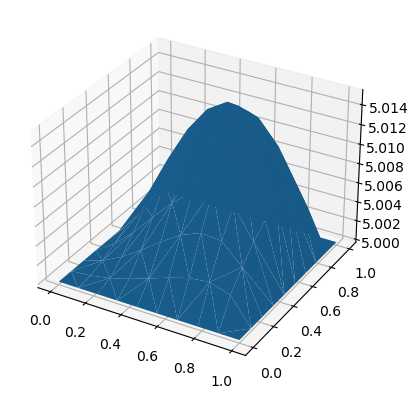

In [7]:
show(coordinates,U_k)

**Partie II : maillage mixte et ajoût des conditions de Neumann**

In [86]:
############################# Maillage mixte ################
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
dds=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
ccs=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])

In [155]:
N_Q = len(e4)
N_T = len(e3)

N_S = len(ccs)

A = np.zeros((N_S,N_S))
b_f = np.zeros(N_S)
U_k = np.zeros(N_S)

b_q = np.zeros(4)
b_t = np.zeros(3)

M_T = np.ones((3,3))
M_Q = np.ones((4,4))

U_k[dds] = 1

f = lambda x, y : 1
g = lambda x, y : 1

for i in range(N_T) : 
    Tp = e3[i] # Chaque ligne contient les indices des sommets d'un element triangle

    x1 = ccs[Tp[0]][0]
    x2 = ccs[Tp[1]][0]
    x3 = ccs[Tp[2]][0]
    y1 = ccs[Tp[0]][1]
    y2 = ccs[Tp[1]][1]
    y3 = ccs[Tp[2]][1]
    
    # a = np.zeros((2,2))
    # a[0,0] = x2 - x1
    # a[0,1] = x3 - x1
    # a[1,0] = y2 - y1
    # a[1,1] = y3 - y1
    # alpha =  np.linalg.det(a)
    alpha = (x2-x1)*(y3-y1) - (y2-y1)*(x3-x1)

    grad1 = [y2-y3, x3-x2]/alpha
    grad2 = [y3-y1,x1-x3]/alpha
    grad3 = [y1-y2,x2-x1]/alpha

    M_T[0,0] = alpha * np.dot(grad1, grad1)/2
    M_T[0,1] = alpha * np.dot(grad1, grad2)/2
    M_T[0,2] = alpha * np.dot(grad1, grad3)/2
    M_T[1,0] = alpha * np.dot(grad2, grad1)/2
    M_T[1,1] = alpha * np.dot(grad2, grad2)/2
    M_T[1,2] = alpha* np.dot(grad2, grad3)/2
    M_T[2,0] = alpha* np.dot(grad3, grad1)/2
    M_T[2,1] = alpha* np.dot(grad3, grad2)/2
    M_T[2,2] = alpha* np.dot(grad3, grad3)/2

    A[Tp, Tp[0]] = A[Tp, Tp[0]] + M_T[:,0]
    A[Tp, Tp[1]] = A[Tp, Tp[1]] + M_T[:,1]
    A[Tp, Tp[2]] = A[Tp, Tp[2]] + M_T[:,2]


    xg = (x1+x2+x3)/3
    yg = (y1+y2+y3)/3

    b_t[0] = alpha/6 * f(xg,yg)
    b_t[1] = alpha/6 * f(xg,yg)
    b_t[2] = alpha/6 * f(xg,yg)

    b_f[Tp] = b_f[Tp] + b_t

print(Tp)
    
for i in range(N_Q) : 
    Tq = e4[i] # Chaque ligne contient les indices des sommets d'un element triangle

    x1 = ccs[Tq[0]][0]
    x2 = ccs[Tq[1]][0]
    x3 = ccs[Tq[2]][0]
    x4 = ccs[Tq[3]][0]
    y1 = ccs[Tq[0]][1]
    y2 = ccs[Tq[1]][1]
    y3 = ccs[Tq[2]][1]
    y4 = ccs[Tq[3]][1]

    J = np.array([[x2-x1, y2-y1], [x4-x1,y4-y1]])

    inv = np.linalg.inv(np.dot(J.T, J))
    a = inv[0,0]
    b = inv[0,1]
    c = inv[1,1]

    
    x = np.array([x1,x2,x3,x4])
    y = np.array([y1,y2,y3,y4])
    
    aire_q = 0.5 * np.abs(np.dot(x,np.roll(y,1)) - np.dot(y,np.roll(x,1)))

    alpha = (x2-x1)*(y3-y1) - (y2-y1)*(x3-x1)
    
    M_Q[0,0] = (a/3 + c/3 + b/2)*aire_q
    M_Q[0,1] = (-a/3 + c/6)*aire_q
    M_Q[1,0] = (-a/3 + c/6)*aire_q
    M_Q[0,2] = (-a/6-c/6-b/2)*aire_q
    M_Q[2,0] = (-a/6-c/6-b/2)*aire_q
    M_Q[0,3] = (a/6 - c/3)*aire_q
    M_Q[3,0] = (a/6 - c/3)*aire_q
    M_Q[1,1] = (a/3 + c/3 -b/2)*aire_q
    M_Q[1,2] = (a/6 - c/3)*aire_q
    M_Q[2,1] = (a/6 - c/3)*aire_q
    M_Q[1,3] = (-a/6 -c/6 +b/2)*aire_q
    M_Q[3,1] = (-a/6 -c/6 +b/2)*aire_q
    M_Q[2,2] = (a/3+c/3+b/2)*aire_q
    M_Q[2,3] = (-a/3+c/6)*aire_q
    M_Q[3,2] = (-a/3+c/6)*aire_q
    M_Q[3,3] = (a/3-b/2+c/3)*aire_q

    A[Tq, Tq[0]] = A[Tq, Tq[0]] + M_Q[:,0]
    A[Tq, Tq[1]] = A[Tq, Tq[1]] + M_Q[:,1]
    A[Tq, Tq[2]] = A[Tq, Tq[2]] + M_Q[:,2]
    A[Tq, Tq[3]] = A[Tq, Tq[3]] + M_Q[:,3]


    xg = (x1+x2+x3+x4)/4
    yg = (y1+y2+y3+y4)/4

    b_q[0] = alpha * f(xg,yg)/4
    b_q[1] = alpha * f(xg,yg)/4
    b_q[2] = alpha * f(xg,yg)/4
    b_q[3] = alpha * f(xg,yg)/4

    b_f[Tq] = b_f[Tq] + b_q



for a1,a2 in nns:
    l = np.sqrt((ccs[a1][0] - ccs[a2][0])**2 + (ccs[a1][1] - ccs[a2][1])**2)
    milieu = ((ccs[a1][0] + ccs[a2][0])/2, (ccs[a1][1] + ccs[a2][1])/2)
    b_f[a1] = b_f[a1] + l* g(milieu[0], milieu[1])/2
    b_f[a2] = b_f[a2] + l* g(milieu[0], milieu[1])/2
    
    
b_f = b_f - np.dot(A,U_k)

[ 3 15  4]


In [156]:
masque = np.ones(N_S, dtype=bool)
masque[dds] = False
x = np.linalg.solve(A[np.ix_(masque,masque)], b_f[masque])
U_k[masque] = x

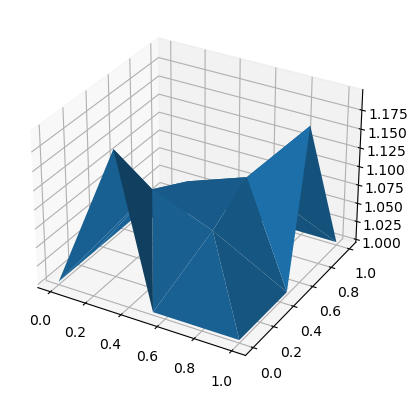

In [159]:
show(ccs,U_k)

**Compléments  :  un nouveau terme dans l'EDP**